In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import pydotplus
from sklearn import tree
from IPython.display import Image
import itertools
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import os, errno
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import DBSCAN


# Utilities 

In [2]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, save="False", path="./confusion_matrix/cm_DT"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save is True:
        plt.savefig(path+".pdf")
    plt.clf()

# Filtering Attributes

In [3]:
reduced = pd.read_csv("./outCompleta.csv")
reduced["sums"] = reduced.iloc[:, 5:10].sum(axis=1)
reduced["g3"] = reduced.iloc[:, 5:10].ge(1,axis=1).sum(axis=1)

cols = reduced.columns.tolist()
cols.remove('age')
cols.remove('status')
cols.remove('education')
cols.remove('sex')
cols.remove('credit_default')
cols.remove('pa-apr')
cols.remove('pa-may')
cols.remove('pa-jun')
cols.remove('pa-jul')
cols.remove('pa-aug')
cols.remove('pa-sep')
cols.remove('ps-apr')
cols.remove('ps-may')
cols.remove('ps-jun')
cols.remove('ps-jul')
cols.remove('ps-aug')
cols.remove('ps-sep')
cols.remove('sums')
cols.remove('ba-apr')
cols.remove('ba-may')
cols.remove('ba-jun')
cols.remove('ba-jul')
cols.remove('ba-aug')
cols.remove('ba-sep')
cols.remove('g3')

    
reduced = reduced.filter(['g3','ps-sep','ps-apr','ps-jul','ps-aug','ps-jun','ps-may','credit_default'], axis=1)
#reduced = reduced.filter(['ps-sep','g3','ps-apr','credit_default'], axis=1)
#reduced= reduced.drop(columns=['limit','varps','ps-apr','ps-may','ps-aug','ps-jul','ps-jun','ba-sep','ba-sep','ba-aug','ba-jul','ba-jun','ba-may','ba-apr','pa-sep','pa-aug','pa-jun','pa-may','pa-apr','sums'])
#print(reduced.head)

reduced['credit_default'].replace({0: 'false', 1: 'true'}, inplace=True)

# Spit dataset in Training and Test set

In [4]:
attributes = [col for col in reduced.columns if col != 'credit_default']
X = reduced[attributes]
y = reduced['credit_default']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=100, stratify=y)

# UnderSampling

In [5]:
rat=1

sm = RandomUnderSampler(ratio=rat, random_state=42)

X_train, y_train = sm.fit_sample(X_train, y_train)
X_train.shape, y_train.shape 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3096, 7)
(3096,)
(3000, 7)
(3000,)


# Grid Search

In [6]:

param_grid = {'criterion': ['gini', 'entropy'],'min_samples_split' : range(2,300,50),'min_samples_leaf' : range(2,300,50),'max_depth': np.arange(2, 7)}
dt1 = GridSearchCV(DecisionTreeClassifier(splitter="best"), param_grid, cv=StratifiedKFold(15), scoring='accuracy')
dt1_fit = dt1.fit(X_train, y_train)

tree_performance = roc_auc_score(y_test, dt1_fit.predict_proba(X_test)[:, 1])
print("DecisionTree: Area under the ROC curve = {}".format(tree_performance))
opt_dt1 = dt1_fit.best_estimator_
print("{}".format(dt1_fit.best_params_))


DecisionTree: Area under the ROC curve = 0.7560373127785114
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 52, 'min_samples_split': 2}


# Cross Validation

In [7]:
scores = cross_val_score(opt_dt1, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
cva=('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(opt_dt1, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
cvf=('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8213 (+/- 0.01)
F1-score: 0.6830 (+/- 0.04)


# Decision Tree


g3 0.6954539767558132
ps-sep 0.16922795145234557
ps-apr 0.04990863209284918
ps-jul 0.004110678458182943
ps-aug 0.06122283938860133
ps-jun 0.012823014714496914
ps-may 0.007252907137710841


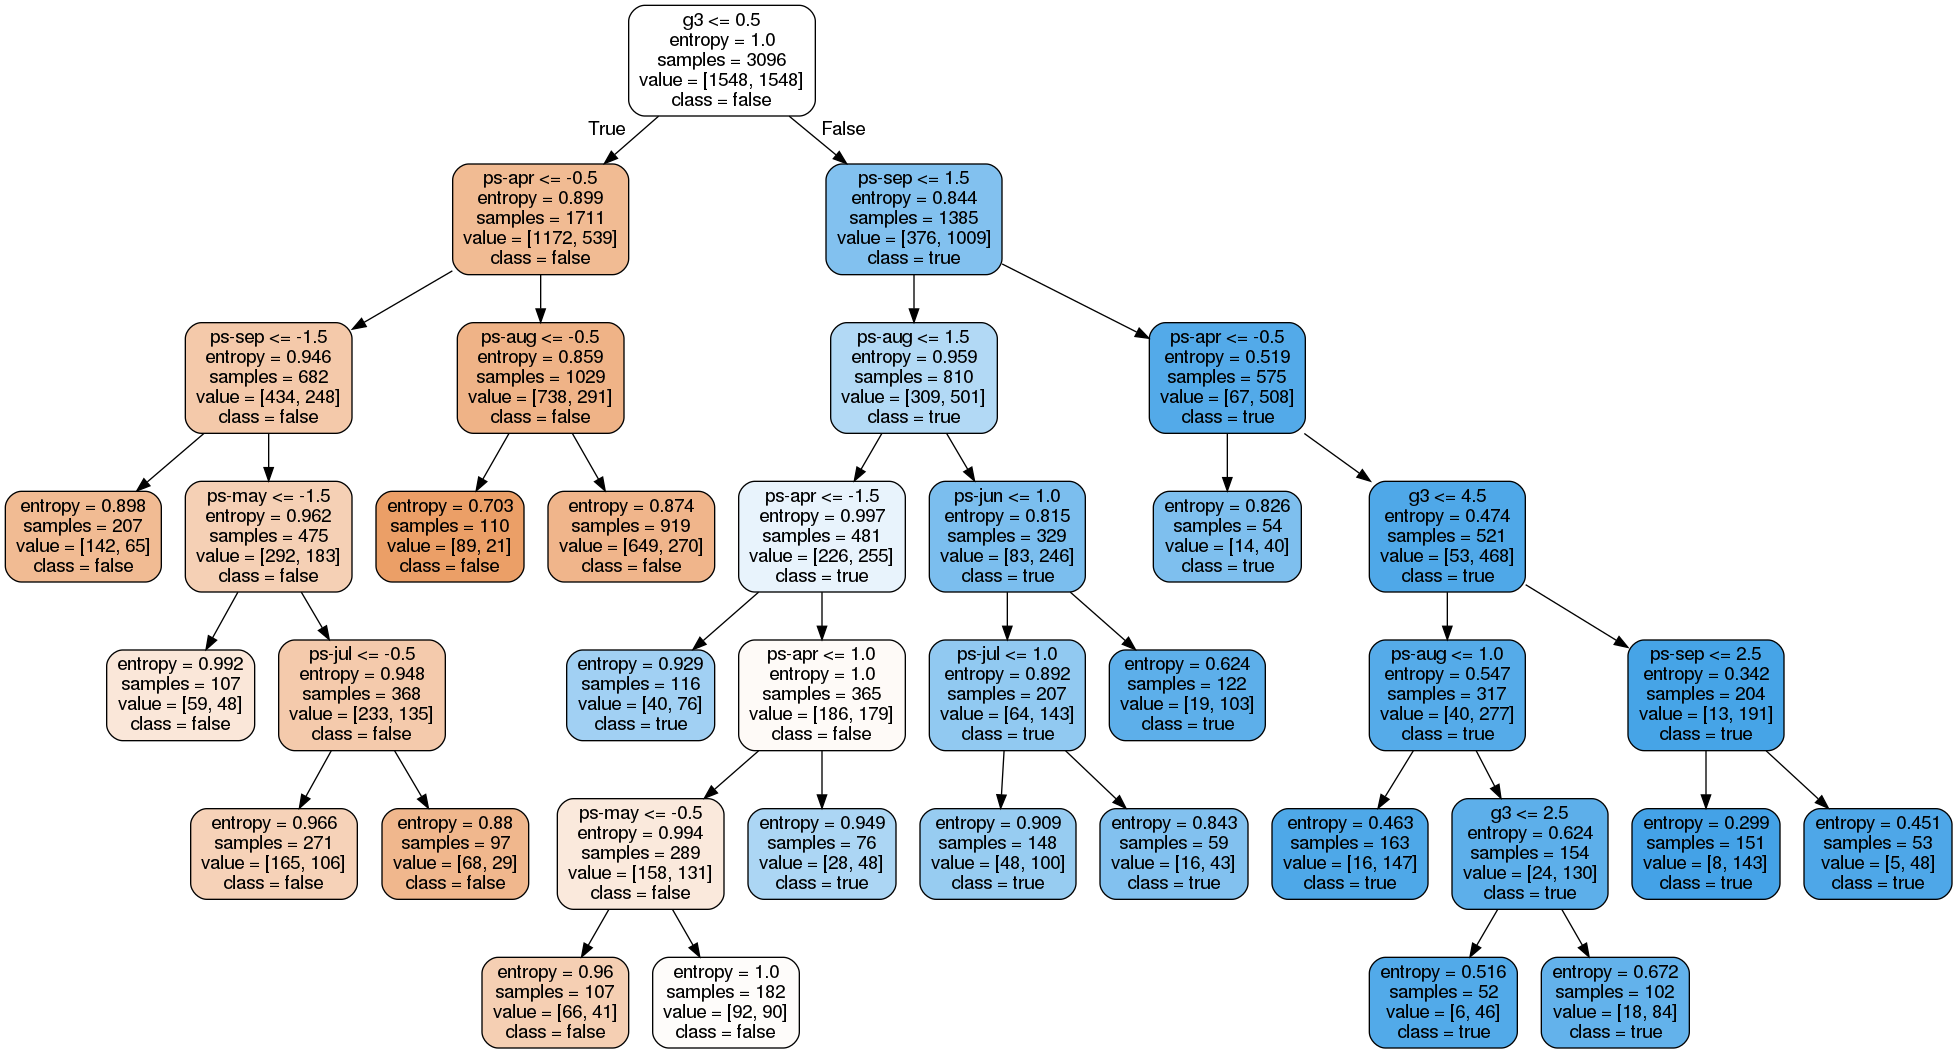

In [8]:
for col, imp in zip(attributes, opt_dt1.feature_importances_):
    print(col, imp)
    
dot_data = tree.export_graphviz(opt_dt1, out_file=None,  
                                feature_names=attributes, 
                                class_names=opt_dt1.classes_,  
                                filled=True, rounded=True,  
                                special_characters=False)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# Scores

In [9]:
y_pred1 = opt_dt1.predict(X_train)
a1 = ('Accuracy %s' % accuracy_score(y_train, y_pred1))
print(a1)
r1 = ('Recall: %s' %  recall_score(y_train, y_pred1, average='weighted'))
print(r1)
p1 = ('Precision: %s' %  precision_score(y_train, y_pred1, average='weighted'))
print(p1)
f1=('F1-score %s' % f1_score(y_train, y_pred1, average='weighted'))
print(f1)

Accuracy 0.7131782945736435
Recall: 0.7131782945736435
Precision: 0.7330474452554745
F1-score 0.7069316927821089


In [10]:
report1 = classification_report(y_train, y_pred1)
print(report1)
cm1 = confusion_matrix(y_train, y_pred1)
plot_confusion_matrix(cm1, classes=opt_dt1.classes_, normalize=True, title='Normalized confusion matrix')

              precision    recall  f1-score   support

       false       0.67      0.86      0.75      1548
        true       0.80      0.57      0.66      1548

   micro avg       0.71      0.71      0.71      3096
   macro avg       0.73      0.71      0.71      3096
weighted avg       0.73      0.71      0.71      3096

Normalized confusion matrix
[[0.85917313 0.14082687]
 [0.43281654 0.56718346]]


<Figure size 432x288 with 0 Axes>

In [11]:
y_pred2 = opt_dt1.predict(X_test)
a2=('Accuracy %s' % accuracy_score(y_test, y_pred2))
print(a2)
r2=('Recall: %s' %  recall_score(y_test, y_pred2, average='weighted'))
print(r2)
p2=('Precision: %s' %  precision_score(y_test, y_pred2, average='weighted'))
print(p2)
f2=('F1-score %s' % f1_score(y_test, y_pred2, average='weighted'))
print(f2)

Accuracy 0.8013333333333333
Recall: 0.8013333333333333
Precision: 0.8046161864842416
F1-score 0.8028857721975423


In [12]:
report2 = classification_report(y_test, y_pred2)
print(report2)
cm2 =confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(cm2, classes=opt_dt1.classes_, normalize=True, title='Normalized confusion matrix', save=True)

              precision    recall  f1-score   support

       false       0.88      0.87      0.87      2336
        true       0.55      0.57      0.56       664

   micro avg       0.80      0.80      0.80      3000
   macro avg       0.71      0.72      0.72      3000
weighted avg       0.80      0.80      0.80      3000

Normalized confusion matrix
[[0.86601027 0.13398973]
 [0.42620482 0.57379518]]


<Figure size 432x288 with 0 Axes>